In [1]:
import pandas as pd
import numpy as np

from sklearn import metrics
from sklearn import preprocessing
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import seaborn as sns

from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

In [2]:
from scipy.special import softmax

def binary_cls(cls):
    if cls == 0 or cls == 1:
        return 0
    elif cls == 2 or cls == 3:
        return 1
    else:
        return None
    
def binary_pred(pred):
    pred = np.array(pred.split(','), dtype=float)
    pred_b = np.array([pred[0]+pred[1], pred[2]+pred[3]])
    pred_b = softmax(pred_b)
    return pred_b[1] # the probability to greater label

def group_f1_b(df): 
    label = np.array(df.Class_b.tolist(), dtype=int)
    pred = np.array(df.Pred_b.tolist(), dtype=float)
    pred = np.where(pred > 0.5, 1, 0)
    score = metrics.f1_score(label, pred, average='micro')
    return score

def group_kappa_b(df): 
    label = np.array(df.Class_b.tolist(), dtype=int)
    pred = np.array(df.Pred_b.tolist(), dtype=float)
    pred = np.where(pred > 0.5, 1, 0)
    score = metrics.cohen_kappa_score(label, pred)
    return score

def group_acc_b(df): 
    label = np.array(df.Class_b.tolist(), dtype=int)
    pred = np.array(df.Pred_b.tolist(), dtype=float)
    pred = np.where(pred > 0.5, 1, 0)
    score = metrics.accuracy_score(label, pred)
    return score

def group_auc_b(df): 
    label = np.array(df.Class_b.tolist(), dtype=int)
    pred = np.array(df.Pred_b.tolist(), dtype=float)
    score = metrics.roc_auc_score(label, pred)
    return score

In [3]:
def group_f1(df): 
    label = np.array(df.Class.tolist(), dtype=int)
    pred = np.argmax([np.array(i.split(','), dtype=float) for i in df.Pred.tolist()], axis=1)
    score = metrics.f1_score(label, pred, average='micro')
    return score

def group_kappa(df): 
    label = np.array(df.Class.tolist(), dtype=int)
    pred = np.argmax([np.array(i.split(','), dtype=float) for i in df.Pred.tolist()], axis=1)
    score = metrics.cohen_kappa_score(label, pred)
    return score

def group_acc(df): 
    label = np.array(df.Class.tolist(), dtype=int)
    pred = np.argmax([np.array(i.split(','), dtype=float) for i in df.Pred.tolist()], axis=1)
    score = metrics.accuracy_score(label, pred)
    return score

def group_auc(df): 
    label = np.array(df.Class.tolist(), dtype=int)
    pred = [np.array(i.split(','), dtype=float) for i in df.Pred.tolist()]
    # score = metrics.roc_auc_score(label, pred, multi_class='ovr', average='weighted', labels=[0, 1, 2, 3])
    score = metrics.roc_auc_score(label, pred, multi_class='ovr', average='macro', labels=[0, 1, 2, 3])
    
#     # calculate AUC one-by-one (same to the previous results)
#     lb = preprocessing.LabelBinarizer()
#     class_oh = lb.fit_transform(df.Class)
#     pred = [np.array(i.split(','), dtype=float) for i in df.Pred.tolist()]
#     pred_prob = np.array(pred)
#     # print(class_oh.shape, pred_prob.shape)
#     aucs = []
#     for c in range(4): 
#         fpr, tpr, thresh = metrics.roc_curve(class_oh[:, c], pred_prob[:, c])
#         aucs.append(metrics.roc_auc_score(class_oh[:, c], pred_prob[:, c]))

#     # calculate binary accuracy (AUC sometimes smaller than binary accuracy)
#     cls = df.Class.to_numpy()
#     class_oh = np.zeros((cls.size, 4))
#     class_oh[np.arange(cls.size), cls] = 1
#     pred = np.argmax([np.array(i.split(','), dtype=float) for i in df.Pred.tolist()], axis=1)
#     pred_oh = np.zeros((pred.size, 4))
#     pred_oh[np.arange(pred.size), pred] = 1
#     accs = []
#     for c in range(4):
#         print(class_oh[:, c].shape, pred_oh[:, c].shape)
#         accs.append(metrics.accuracy_score(class_oh[:, c], pred_oh[:, c]))
        
    return score#, np.mean(np.array(accs))#, np.mean(np.array(aucs))

## 1. Independent training

In [4]:
dfs = []
for mb in range(18): 
    for i in range(5):
        dfs.append(pd.read_csv('../results/molnet_chirality_cls_etkdg_csp{}-5fold_{}.csv'.format(str(mb), str(i)), 
                               sep='\t', index_col=0))
df = pd.concat(dfs, ignore_index=True)

In [5]:
df['Class_b'] = df['Class'].apply(binary_cls)
df['Pred_b'] = df['Pred'].apply(binary_pred)

In [6]:
auc = df.groupby('MB').apply(group_auc)
acc = df.groupby('MB').apply(group_acc)
kappa = df.groupby('MB').apply(group_kappa)
f1 = df.groupby('MB').apply(group_f1)

auc_b = df.groupby('MB').apply(group_auc_b)
acc_b = df.groupby('MB').apply(group_acc_b)
kappa_b = df.groupby('MB').apply(group_kappa_b)
f1_b = df.groupby('MB').apply(group_f1_b)

In [7]:
print('Based on 4-classes === >>>')
print('AUC:', '\n'+'\n'.join(auc.astype(str).tolist()), '\n')
print('ACC:', '\n'+'\n'.join(acc.astype(str).tolist()), '\n')
print('KAPPA:', '\n'+'\n'.join(kappa.astype(str).tolist()), '\n')
print('F1:', '\n'+'\n'.join(f1.astype(str).tolist()), '\n')

print('\nBased on 2-classes === >>>')
print('AUC:', '\n'+'\n'.join(auc_b.astype(str).tolist()), '\n')
print('ACC:', '\n'+'\n'.join(acc_b.astype(str).tolist()), '\n')
print('KAPPA:', '\n'+'\n'.join(kappa_b.astype(str).tolist()), '\n')
print('F1:', '\n'+'\n'.join(f1_b.astype(str).tolist()), '\n')

Based on 4-classes === >>>
AUC: 
0.9039913033760016
0.8881746884763462
0.8880827172463008
0.872262851119691
0.8784455120642639
0.9136020691377158
0.8104631938016531
0.9087320981159142
0.7542572219896069
0.7910045735507412
0.7991358759160847
0.6958364577340705
0.8420082244884421
0.7554761044944489
0.8275499748315233
0.7866204786913424
0.8407513687340715
0.7537227987732273 

ACC: 
0.8517241379310345
0.7670329670329671
0.7905405405405406
0.7461538461538462
0.8108614232209738
0.8032786885245902
0.8116863905325444
0.8587628865979381
0.8014032191498143
0.8296875
0.8173160173160173
0.7746521476104054
0.7850299401197605
0.7824884792626728
0.8112
0.8883333333333333
0.7978260869565217
0.7287769784172662 

KAPPA: 
0.7461758449779659
0.6763217588553481
0.6938844103396745
0.6315091978080924
0.6927626095274466
0.6982522747017305
0.6511396738562885
0.7806966335060195
0.596556709357568
0.6250469358993558
0.6357817305766695
0.5238614179592829
0.6581034272347055
0.5619082977538519
0.6552856396671578
0.6

In [8]:
def process_prob(x): 
    x = np.array(x.split(','), dtype=float)
    return x

def plot_roc_curve(mb_idx, save_fig=False, print_confusion_metrics=False):
    lb = preprocessing.LabelBinarizer()
    if mb_idx == 'all':
        df_tmp = df
    else: 
        df_tmp = df[df['MB'] == mb_idx]
        
    class_oh = lb.fit_transform(df_tmp['Class'])
    pred_prob = df_tmp['Pred'].apply(process_prob)
    pred_prob = np.array(pred_prob.tolist())

    f, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9), gridspec_kw={'height_ratios': [0.6, 2]})

    sns.countplot(x=df_tmp["Class"], ax=ax1)

    for c in range(4): 
        fpr, tpr, thresh = metrics.roc_curve(class_oh[:, c], pred_prob[:, c])
        auc = metrics.roc_auc_score(class_oh[:, c], pred_prob[:, c])
        ax2.plot(fpr, tpr, label="class {} vs the rest (AUC={:.2f})".format(c, auc))

    ax2.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
    ax2.axis("square")
    ax2.set_xlabel("False Positive Rate")
    ax2.set_ylabel("True Positive Rate")
    ax2.set_title("One-vs-Rest ROC curves (encoded csp: {})".format(mb_idx))
    ax2.legend()

    plt.subplots_adjust(hspace=.3)
    if save_fig: 
        plt.savefig('./roc_curve_{}.png'.format(str(mb_idx)), dpi=300, bbox_inches='tight')
        print('Save!')
    plt.show()
    
    # confusion metrics
    if print_confusion_metrics: 
        pred = np.argmax(pred_prob, axis=1)
        print('confusion metrics: \n[[tn, fp], \n[fn, tp]]\n')
        print(metrics.multilabel_confusion_matrix(df_tmp['Class'].to_numpy(), pred))

In [14]:
def plot_roc_curve_b(mb_idx, save_fig=False, print_confusion_metrics=False): 
    if mb_idx == 'all':
        df_tmp = df
    else: 
        df_tmp = df[df['MB'] == mb_idx]
        
    f, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9), gridspec_kw={'height_ratios': [0.6, 2]})

    sns.countplot(x=df_tmp["Class_b"], ax=ax1)

    for c in range(1): 
        fpr, tpr, thresh = metrics.roc_curve(df_tmp["Class_b"], df_tmp["Pred_b"])
        auc = metrics.roc_auc_score(df_tmp["Class_b"], df_tmp["Pred_b"])
        ax2.plot(fpr, tpr, label="super-class {} vs the rest (AUC={:.2f})".format(c, auc))

    ax2.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
    ax2.axis("square")
    ax2.set_xlabel("False Positive Rate")
    ax2.set_ylabel("True Positive Rate")
    ax2.set_title("One-vs-Rest ROC curves (encoded csp: {})".format(mb_idx))
    ax2.legend()

    plt.subplots_adjust(hspace=.3)
    if save_fig: 
        plt.savefig('./roc_curve_{}.png'.format(str(mb_idx)), dpi=300, bbox_inches='tight')
        print('Save!')
    plt.show()
    
    # confusion metrics
    if print_confusion_metrics: 
        pred = np.argmax(pred_prob, axis=1)
        print('confusion metrics: \n[[tn, fp], \n[fn, tp]]\n')
        print(metrics.multilabel_confusion_matrix(df_tmp['Class'].to_numpy(), pred))

In [10]:
# def plot_roc_curve_b(mb_idx, save_fig=False, print_confusion_metrics=False): 
#     lb = preprocessing.LabelBinarizer()
#     if mb_idx == 'all':
#         df_tmp = df
#     else: 
#         df_tmp = df[df['MB'] == mb_idx]
        
#     class_oh = lb.fit_transform(df_tmp['Class_b'])
#     class_oh = np.array([[x, 1-x] for x in class_oh])
#     pred_prob = df_tmp['Pred_b'].apply(lambda x: np.array([float(x), 1-float(x)])).tolist()
#     pred_prob = np.array(pred_prob)
    
#     f, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9), gridspec_kw={'height_ratios': [0.6, 2]})

#     sns.countplot(x=df_tmp["Class_b"], ax=ax1)

#     for c in range(2): 
#         fpr, tpr, thresh = metrics.roc_curve(class_oh[:, c], pred_prob[:, c])
#         auc = metrics.roc_auc_score(class_oh[:, c], pred_prob[:, c])
#         ax2.plot(fpr, tpr, label="class {} vs the rest (AUC={:.2f})".format(c, auc))

#     ax2.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
#     ax2.axis("square")
#     ax2.set_xlabel("False Positive Rate")
#     ax2.set_ylabel("True Positive Rate")
#     ax2.set_title("One-vs-Rest ROC curves (encoded csp: {})".format(mb_idx))
#     ax2.legend()

#     plt.subplots_adjust(hspace=.3)
#     if save_fig: 
#         plt.savefig('./roc_curve_{}.png'.format(str(mb_idx)), dpi=300, bbox_inches='tight')
#         print('Save!')
#     plt.show()
    
#     # confusion metrics
#     if print_confusion_metrics: 
#         pred = np.argmax(pred_prob, axis=1)
#         print('confusion metrics: \n[[tn, fp], \n[fn, tp]]\n')
#         print(metrics.multilabel_confusion_matrix(df_tmp['Class'].to_numpy(), pred))

In [11]:
# plot_roc_curve('all', save_fig=True)

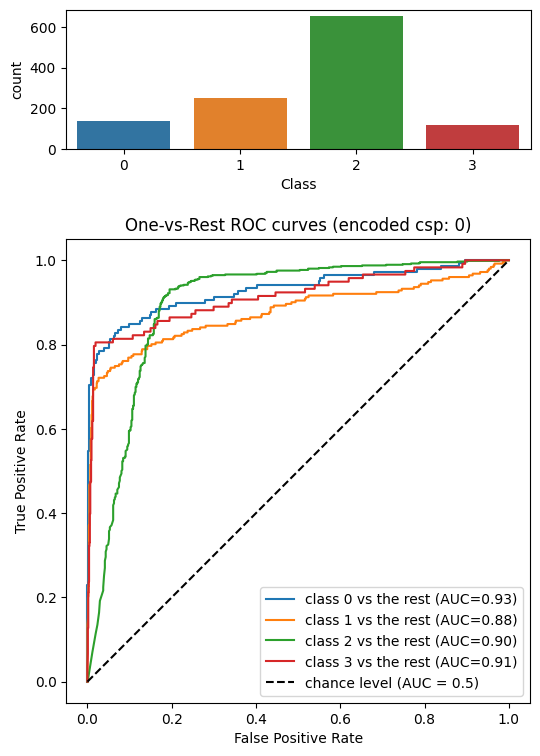

In [18]:
plot_roc_curve(0, save_fig=False)

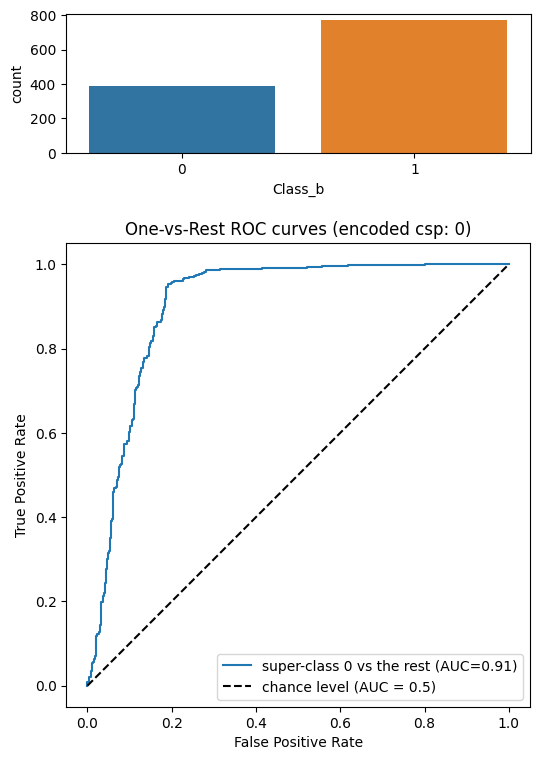

In [19]:
plot_roc_curve_b(0, save_fig=False)

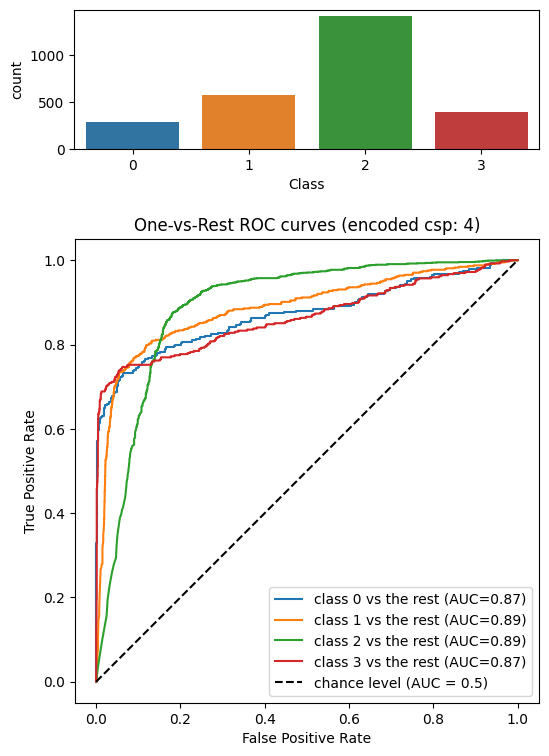

In [16]:
plot_roc_curve(4, save_fig=False)

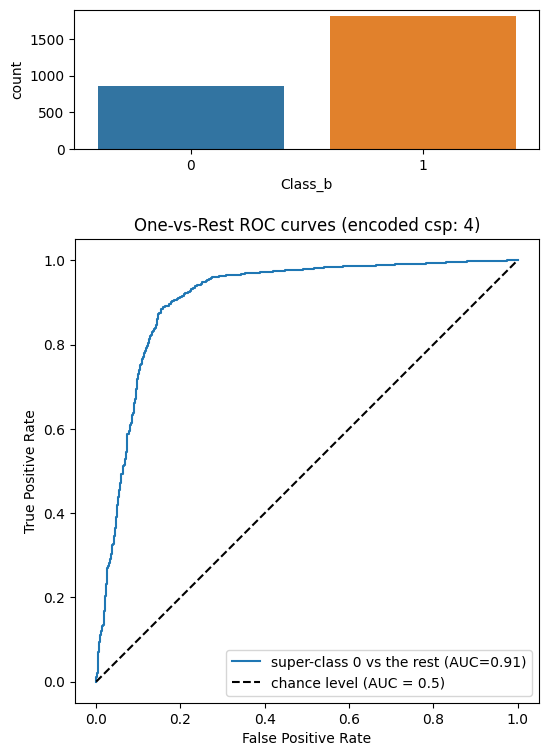

In [17]:
plot_roc_curve_b(4, save_fig=False)

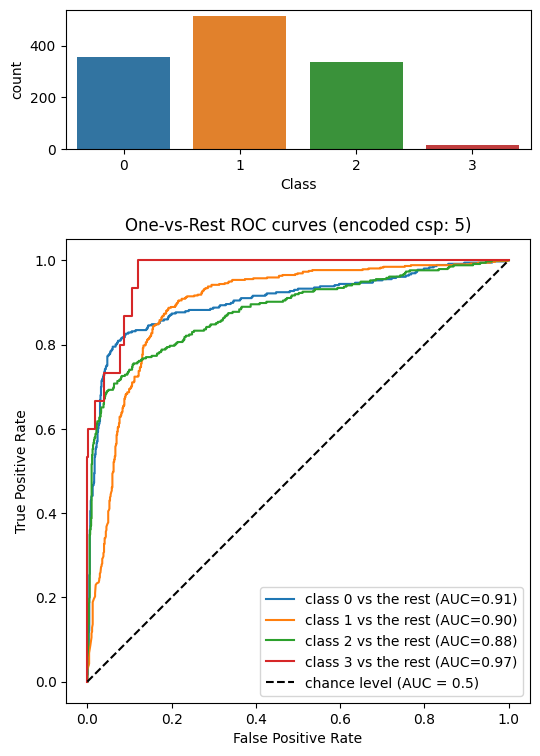

In [12]:
plot_roc_curve(5, save_fig=False)

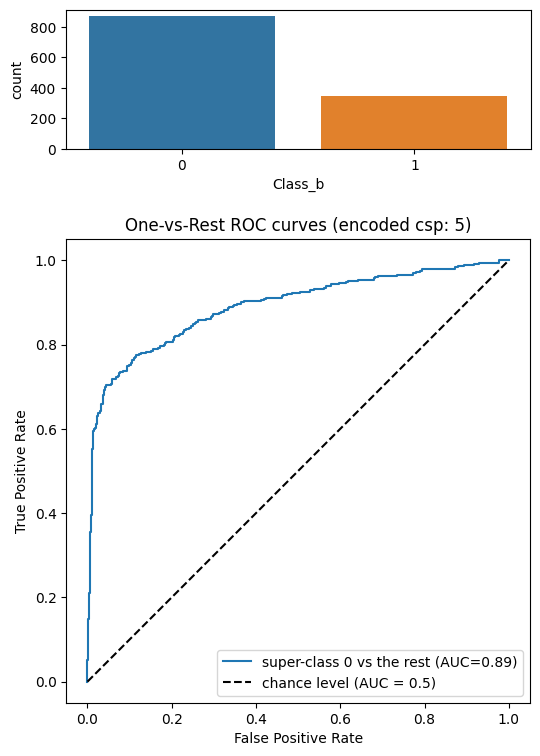

In [15]:
plot_roc_curve_b(5, save_fig=False)

In [10]:
# plot_roc_curve(15, save_fig=True, print_confusion_metrics=True)

## 2. Transfer learning

In [6]:
dfs = []
for mb in range(18): 
    for i in range(5):
        dfs.append(pd.read_csv('../results/molnet_chirality_cls_etkdg_csp{}-5fold_tl_{}.csv'.format(str(mb), str(i)), 
                               sep='\t', index_col=0))
df = pd.concat(dfs, ignore_index=True)

In [7]:
auc = df.groupby('MB').apply(group_auc)
acc = df.groupby('MB').apply(group_acc)
kappa = df.groupby('MB').apply(group_kappa)
f1 = df.groupby('MB').apply(group_f1)

In [8]:
print('AUC:', '\n'+'\n'.join(auc.astype(str).tolist()), '\n')
print('ACC:', '\n'+'\n'.join(acc.astype(str).tolist()), '\n')
print('KAPPA:', '\n'+'\n'.join(kappa.astype(str).tolist()), '\n')
print('F1:', '\n'+'\n'.join(f1.astype(str).tolist()), '\n')

AUC: 
0.9066849009153858
0.892746099262808
0.8870366610552987
0.9155177747227944
0.8815980000877772
0.9109117910620033
0.8407467415731704
0.908688387260658
0.7833454841595351
0.766048862796221
0.8176373972425874
0.7541352678820743
0.8567938711849261
0.7688040358716358
0.866541532990706
0.781347249369147
0.8463199435056363
0.7548714857923193 

ACC: 
0.8724137931034482
0.7769230769230769
0.8050675675675676
0.7923076923076923
0.8299625468164794
0.8155737704918032
0.8349112426035503
0.8804123711340206
0.8129178704085844
0.8298828125
0.8406926406926407
0.8029643073200242
0.7868263473053893
0.8087557603686636
0.836
0.9083333333333333
0.7973913043478261
0.7359712230215827 

KAPPA: 
0.7805439870739794
0.6897213152201663
0.7145587536797406
0.6988369527531755
0.7239880266844818
0.7188911304775267
0.7005908482517142
0.8132661210857682
0.6229985001987868
0.6207329673551161
0.6799706052428681
0.5986985025813325
0.6664980046649441
0.617299889339727
0.70643595492231
0.7111508886486675
0.6704149610328

## ~~3. Multi-task training~~

In [11]:
# df0 = pd.read_csv('../results/molnet_chirality_cls_etkdg_csp_multi_0.csv', sep='\t', index_col=0)

In [12]:
# df0

In [13]:
# df0['Pred_cls'] = df0['Pred'].apply(prob2cls)

In [14]:
# df0

In [15]:
# df0.groupby('MB').apply(group_auc)

## 4. MS/MS dataset and CSP dataset overlaps

In [42]:
ms_df = pd.read_csv('./ALL_MERGE_agilent.txt', sep='\t', index_col=0, names=['SMILES'])

ms_df.dropna(inplace=True)
ms_df = ms_df.drop_duplicates(['SMILES'])
ms_df['Dataset'] = 'Agilent PCDL + NIST20'

In [44]:
csp_df = df[['SMILES']].copy()
csp_df = csp_df.drop_duplicates(['SMILES'])
csp_df['Dataset'] = 'ChirBase'

In [60]:
print(len(ms_df), len(csp_df))

14396 35707


In [45]:
all_df = pd.concat([ms_df, csp_df])

In [46]:
all_df

,SMILES,Dataset
1,CCCCC[C@@](C)(O)/C=C/[C@H]1C(=O)C[C@H](O)[C@@H...,Agilent PCDL + NIST20
2,CSCC[C@H](NC(=O)[C@H](CC(C)C)NC(=O)[C@@H](N)CO...,Agilent PCDL + NIST20
3,CC(C)C[C@H](NC(=O)[C@@H](N)C(C)C)C(=O)N[C@@H](...,Agilent PCDL + NIST20
4,CC(C)[C@H](NC(=O)[C@H](Cc1c[nH]cn1)NC(=O)[C@H]...,Agilent PCDL + NIST20
5,N[C@@H](Cc1c[nH]cn1)C(=O)N[C@@H](Cc1c[nH]cn1)C...,Agilent PCDL + NIST20
...,...,...
76487,N#C/N=C(/Nc1ccc(N)nc1)N[C@@H]1C[C@H]2CC[C@@H]1C2,ChirBase
76501,CC(=O)CC(=O)O[C@H]1N=C(c2ccccc2)c2cc(Cl)ccc2N(...,ChirBase
76652,CCOC(=O)C1=C(C)Nc2cc[nH]c(=O)c2[C@@H]1c1ccccc1...,ChirBase
76669,CC(C)(C)OC(=O)N[C@@H](CCCNC(=O)OCC1c2ccccc2-c2...,ChirBase


In [47]:
ms_smiles = list(set(ms_df['SMILES'].tolist()))
csp_smiles = list(set(df['SMILES'].tolist()))

overlap_smiles = [s for s in ms_smiles if s in csp_smiles]

In [48]:
len(overlap_smiles)

102

In [49]:
ms_fps = []
for s in ms_smiles:
    mol = Chem.MolFromSmiles(s)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2)
    arr = np.zeros((1,))
    DataStructs.ConvertToNumpyArray(fp, arr)
    ms_fps.append(arr)
    
csp_fps = []
for s in csp_smiles:
    mol = Chem.MolFromSmiles(s)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2)
    arr = np.zeros((1,))
    DataStructs.ConvertToNumpyArray(fp, arr)
    csp_fps.append(arr)

In [50]:
tsne = TSNE(random_state=0)
res = tsne.fit_transform(ms_fps+csp_fps)

/home/yuhhong/miniconda3/envs/molnet/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/yuhhong/miniconda3/envs/molnet/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [51]:
res.shape

(50103, 2)

In [52]:
all_df['x'] = res[:,0]
all_df['y'] = res[:,1]

In [54]:
all_df

,SMILES,Dataset,x,y
1,CCCCC[C@@](C)(O)/C=C/[C@H]1C(=O)C[C@H](O)[C@@H...,Agilent PCDL + NIST20,-13.954484,-59.690800
2,CSCC[C@H](NC(=O)[C@H](CC(C)C)NC(=O)[C@@H](N)CO...,Agilent PCDL + NIST20,61.775211,25.781462
3,CC(C)C[C@H](NC(=O)[C@@H](N)C(C)C)C(=O)N[C@@H](...,Agilent PCDL + NIST20,-13.654983,-57.606888
4,CC(C)[C@H](NC(=O)[C@H](Cc1c[nH]cn1)NC(=O)[C@H]...,Agilent PCDL + NIST20,-59.474178,-3.154779
5,N[C@@H](Cc1c[nH]cn1)C(=O)N[C@@H](Cc1c[nH]cn1)C...,Agilent PCDL + NIST20,-59.451988,26.075287
...,...,...,...,...
76487,N#C/N=C(/Nc1ccc(N)nc1)N[C@@H]1C[C@H]2CC[C@@H]1C2,ChirBase,-40.440823,-15.378661
76501,CC(=O)CC(=O)O[C@H]1N=C(c2ccccc2)c2cc(Cl)ccc2N(...,ChirBase,-19.371630,39.841801
76652,CCOC(=O)C1=C(C)Nc2cc[nH]c(=O)c2[C@@H]1c1ccccc1...,ChirBase,3.064277,-29.358868
76669,CC(C)(C)OC(=O)N[C@@H](CCCNC(=O)OCC1c2ccccc2-c2...,ChirBase,32.340305,21.273640


<Figure size 432x288 with 0 Axes>

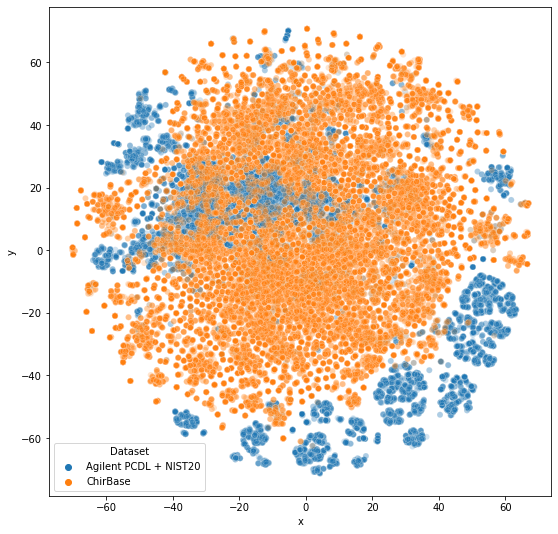

In [59]:
plt.clf()
plt.figure(figsize=(9, 9))
sns.scatterplot(data=all_df, x='x', y='y', hue='Dataset', alpha=0.2, markers='.')

# plt.title('t-SNE on fingerprints Agilent PCDL + NIST20 and ChirBase dataset')
plt.show()